<a href="https://colab.research.google.com/github/meisamgh/Machine_Learning_Trading/blob/main/Volatility_and_Value_at_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance 
import yfinance

In [ ]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
data = yf.download(tickers='BTC-USD', period = '3mo', interval = '60m')
data.tail(10)


In [ ]:
data['returns']= data.Close.pct_change()*100
data.dropna(axis = 0 , inplace = True)

In [ ]:
!pip install arch
!pip install pykalman
!pip install hmmlearn

In [ ]:
from arch.univariate import GARCH, EGARCH , arch_model , HARCH

am = arch_model(data.returns, vol='Garch', p=1, o=0, q=1, dist="skewt")
garch_sk = am.fit(update_freq=5 )

am = arch_model(data.returns, vol='Garch', p=1, o=0, q=1, dist="ged")
garch_g = am.fit(update_freq=5)

am = arch_model(data.returns, vol='Garch', p=1, o=1, q=1, dist="skewt")
gjr_garch_sk = am.fit(update_freq=5)

am = arch_model(data.returns, vol='Garch', p=1, o=1, q=1, dist="ged")
gjr_garch_g = am.fit(update_freq=5)

am = arch_model(data.returns, vol='EGarch', p=1, o=1, q=1, dist="skewt")
egarch_sk = am.fit(update_freq=5)

am = arch_model(data.returns, vol='EGarch', p=1, o=1, q=1, dist="ged")
egarch_g = am.fit(update_freq=5)

am = arch_model(data.returns, vol='harch', p=[1, 5, 22], dist="ged")
harch_ged = am.fit(update_freq=5)

am = arch_model(data.returns, vol='harch', p=[1, 5, 22], dist="skewt")
harch_sk = am.fit(update_freq=5)

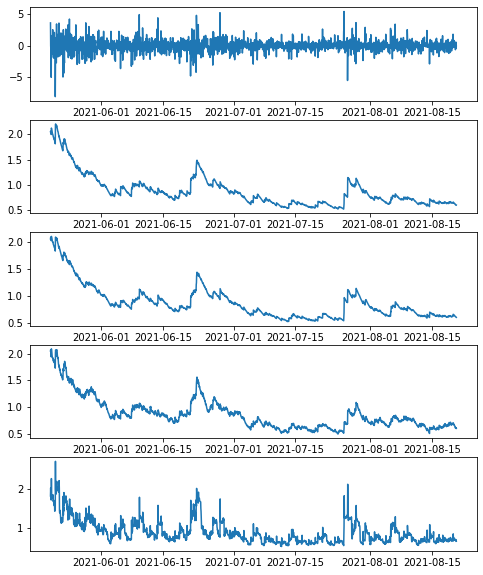

In [ ]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(5, 1, 1)
plt.plot(data.returns)

ax2 = fig.add_subplot(5, 1, 2)
plt.plot(gjr_garch_g.conditional_volatility)

ax3 = fig.add_subplot(5, 1, 3)
plt.plot(garch_g.conditional_volatility)

ax3 = fig.add_subplot(5, 1, 4)
plt.plot(egarch_g.conditional_volatility)

ax3 = fig.add_subplot(5, 1, 5)
plt.plot(harch_ged.conditional_volatility)

In [ ]:
last_observation = '2021-07-01'

am = arch_model(data.returns, vol='Garch', p=1, o=0, q=1, dist="skewt")
garch_sk = am.fit(update_freq=5 , disp='off', last_obs= last_observation)

am = arch_model(data.returns, vol='Garch', p=1, o=0, q=1, dist="ged")
garch_g = am.fit(update_freq=5 ,disp='off' , last_obs= last_observation)

am = arch_model(data.returns, vol='Garch', p=1, o=1, q=1, dist="skewt")
gjr_garch_sk = am.fit(update_freq=5, disp='off', last_obs= last_observation)

am = arch_model(data.returns, vol='Garch', p=1, o=1, q=1, dist="ged")
gjr_garch_g = am.fit(update_freq=5,disp='off', last_obs= last_observation)

am = arch_model(data.returns, vol='EGarch', p=1, o=1, q=1, dist="skewt")
egarch_sk = am.fit(update_freq=5,disp='off', last_obs= last_observation)

am = arch_model(data.returns, vol='EGarch', p=1, o=1, q=1, dist="ged")
egarch_g = am.fit(update_freq=5,disp='off', last_obs= last_observation)

am = arch_model(data.returns, vol='harch', p=[1, 5, 22], dist="ged")
harch_ged = am.fit(update_freq=5,disp='off', last_obs= last_observation)

am = arch_model(data.returns, vol='harch', p=[1, 5, 22], dist="skewt")
harch_sk = am.fit(update_freq=5, disp='off',last_obs= last_observation)

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [ ]:
forecasts = garch_sk.forecast(start='2021-07-01')

first_forecast = '2021-07-01'
cond_mean = forecasts.mean[first_forecast:]
cond_var = forecasts.variance[first_forecast:]
q = am.distribution.ppf([0.01, 0.05], garch_sk.params[-2:])

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


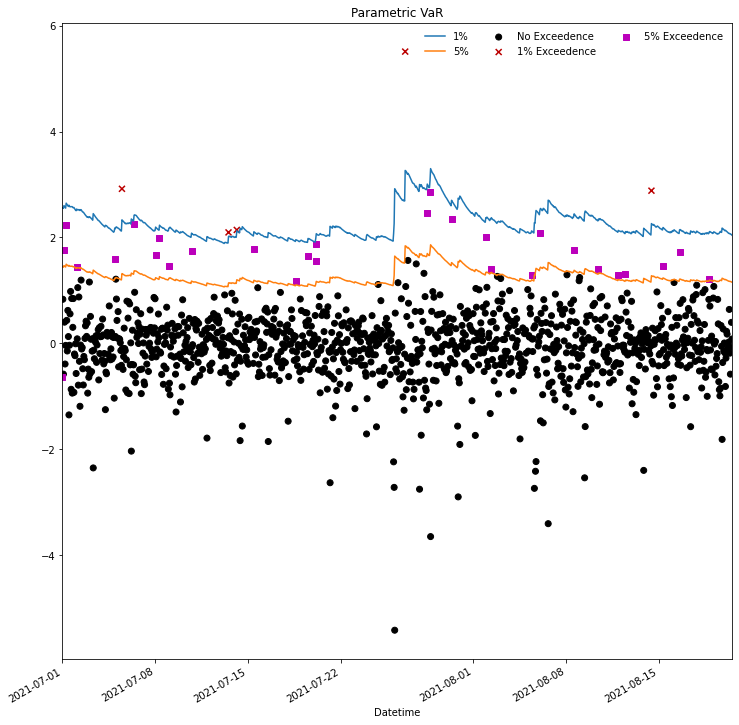

In [ ]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)

ax = value_at_risk.plot(figsize=(12,13) , legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = data.returns[first_forecast:].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


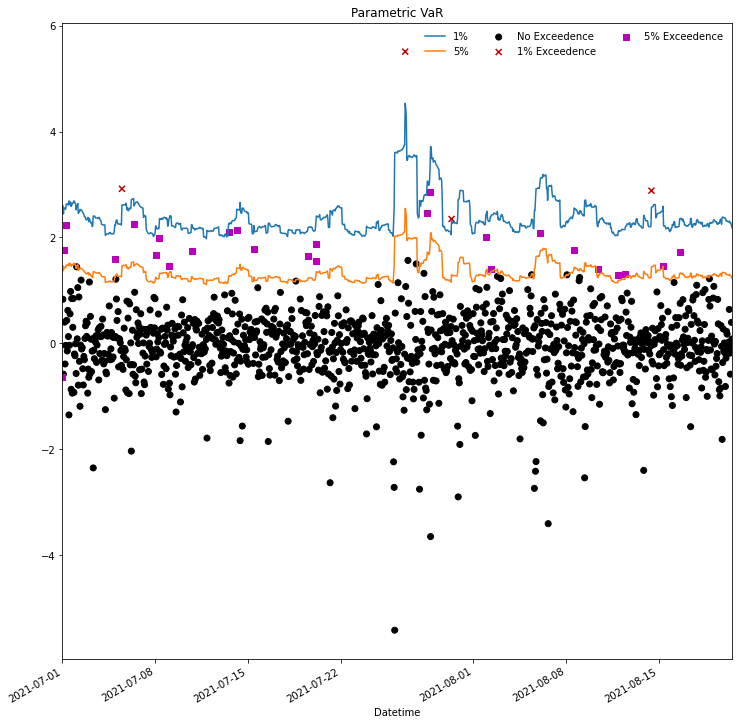

In [ ]:
forecasts = harch_ged.forecast(start='2021-07-01')

first_forecast = '2021-07-01'
cond_mean = forecasts.mean[first_forecast:]
cond_var = forecasts.variance[first_forecast:]
q = am.distribution.ppf([0.01, 0.05], garch_sk.params[-2:])

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)

ax = value_at_risk.plot(figsize=(12,13) , legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = data.returns[first_forecast:].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


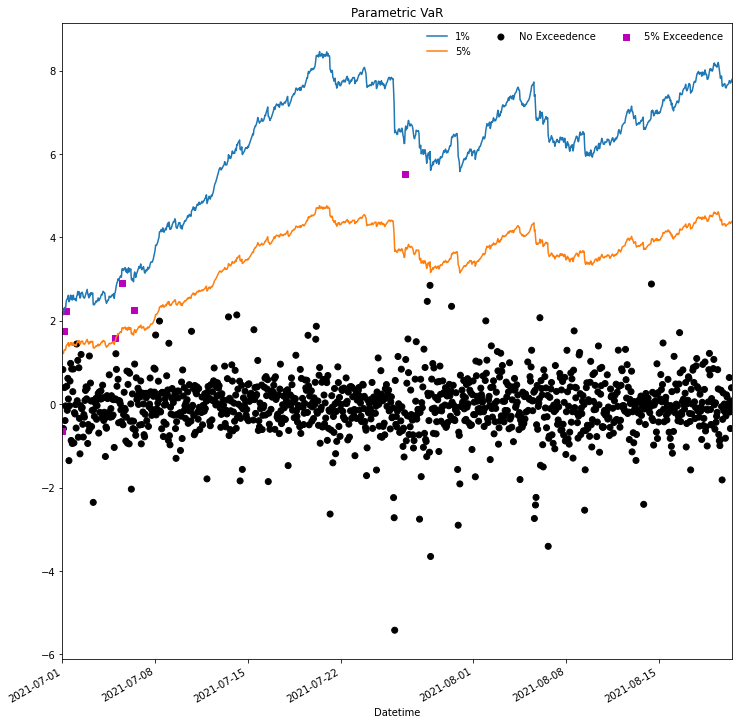

In [ ]:
forecasts = egarch_g.forecast(start='2021-07-01')
first_forecast = '2021-07-01'
cond_mean = forecasts.mean[first_forecast:]
cond_var = forecasts.variance[first_forecast:]
q = am.distribution.ppf([0.01, 0.05], garch_sk.params[-2:])


value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)

ax = value_at_risk.plot(figsize=(12,13) , legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = data.returns[first_forecast:].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)


In [ ]:
tickers = ['AAPL'] #,'GOGO','TSLA','NKE']
data = web.DataReader(tickers , 'yahoo', start='2020/01/01', end='2020/02/15')
data.columns = ['Adj close' , 'Close' , 'High' , 'Low' , 'Open' , 'Volume']
data['Return'] = data['Close'].pct_change()
data['open']=data['Open'].shift(1)
data['high']=data['High'].shift(1)
data['low']=data['Low'].shift(1)
data['close']=data['Close'].shift(1)
data['volume']=data['Volume'].shift(1)
data['adj close']=data['Adj close'].shift(1)
data['returns']= data['Return'].shift(1)
data.dropna(axis=0, inplace= True)

from hmmlearn.hmm import GaussianHMM

states = 2
hmm_model = GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(data[['returns']].values)
regime = pd.DataFrame(hmm_model.predict(data[["returns"]].values))
regime.columns = ['state']

posterior =pd.DataFrame(hmm_model.predict_proba(data[["returns"]].values))
name = []
for i in range(states):
   name.append(f'posterior_state{i}')

posterior.columns = name

/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'AAPL', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


RemoteDataError: ignored

In [ ]:
from hmmlearn.hmm import GaussianHMM
prob_process = pd.DataFrame()

states = 2
hmm_model = GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(data[['returns']].values)
regime = pd.DataFrame(hmm_model.predict(data[["returns"]].values))
regime.columns = ['state']

posterior =pd.DataFrame(hmm_model.predict_proba(data[["returns"]].values))
name = []
for i in range(states):
   name.append(f'posterior_state{i}')

posterior.columns = name


In [ ]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(3, 1, 1)
plt.plot(posterior.iloc[:, 0] , 'g--')
plt.plot(posterior.iloc[:,1], 'r--')

ax2 = fig.add_subplot(3, 1, 2)
plt.plot(data["returns"])

ax3= fig.add_subplot(3, 1, 3)
plt.plot(regime , 'k--')

In [ ]:
tickers = ['AAPL'] #,'GOGO','TSLA','NKE']
data =yf.download(tickers , start='2016/01/01', end='2020/02/20')
data.columns = ['Adj close' , 'Close' , 'High' , 'Low' , 'Open' , 'Volume']
data['Return'] = data['Close'].pct_change()
data['open']=data['Open'].shift(1)
data['high']=data['High'].shift(1)
data['low']=data['Low'].shift(1)
data['close']=data['Close'].shift(1)
data['volume']=data['Volume'].shift(1)
data['adj close']=data['Adj close'].shift(1)
data['returns']= data['Return'].shift(1)
data.dropna(axis=0, inplace= True)

states = 2
hmm_model = GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(data[['returns']].values)
regime = pd.DataFrame(hmm_model.predict(data[["returns"]].values))
regime.columns = ['state']

posterior =pd.DataFrame(hmm_model.predict_proba(data[["returns"]].values))
name = []
for i in range(states):
   name.append(f'posterior_state{i}')

posterior.columns = name

fig = plt.figure(figsize=(13, 10))
ax1 = fig.add_subplot(3, 1, 1)
plt.plot(posterior.iloc[:, 0] , 'g--')
plt.plot(posterior.iloc[:,1], 'r--')

ax2 = fig.add_subplot(3, 1, 2)
plt.plot(data["returns"])

ax3= fig.add_subplot(3, 1, 3)
plt.plot(regime)

In [ ]:
from pykalman import KalmanFilter

kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
denoise , _ = kf.filter(data.close.values)

kalman = pd.Series(denoise.flatten(), index = data.index)


In [ ]:
fig = plt.figure(figsize=(12, 7))
plt.plot(kalman , 'g--' ,label = 'kalman_filter')
plt.plot(data.close , 'r' ,label = 'Close Price' )
plt.legend()